# ACTIVATION FUNCTION COMPARISON

In [1]:
import pandas as pd
import datetime, os
import numpy as np
import numpy.random as npr
from pylab import plt, mpl
import time

from scipy.stats import norm
from scipy import optimize
import scipy.integrate as integrate
import scipy.special as special 

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorboard.plugins.hparams import api as hp
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/ 

Lets save the dataframe as a CSV so we dont need to run it again, but can just load it when needed.

In [2]:
'''
Options_input.to_csv("/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Heston_data_input.csv")
Options_output.to_csv("/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Heston_data_output.csv")
'''

#To read the import the csv-file, use:
raw_Options_input = pd.read_csv (r"/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Options_input.csv")
raw_Options_output = pd.read_csv (r"/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Options_output.csv")

#Creates some unnamed column in the beginning, delete it:
del raw_Options_input['Unnamed: 0']
del raw_Options_output['Unnamed: 0']


In [3]:
Options_input = raw_Options_input.copy()
Options_output = raw_Options_output.copy()

Since the standard deviation is calculated by taking the sum of the squared deviations from the mean, a zero standard deviation can only be possible when all the values of a variable are the same (all equal to the mean). In this case, those variables have no discriminative power so they can be removed from the analysis. They cannot improve any classification, clustering or regression task. Many implementations will do it for you or throw an error about a matrix calculation.

### **Data preparation**

We split our dataset into a training set and a test set (validation set is taken from the training set during model.fit).

In [4]:
# 90% for training and validating
train_dataset = Options_input.sample(frac=0.9, random_state=42)
test_dataset = Options_input.drop(train_dataset.index)

train_labels = Options_output.sample(frac=0.9, random_state=42)
test_labels = Options_output.drop(train_labels.index)

Check the overall statistics

In [5]:
train_stats = train_dataset.describe().T

In [6]:
#normalize the data
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset).values
normed_test_data = norm(test_dataset).values

#make the labels into numpy array just like the normed training data
train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)

'''
#standardise the data
scaler = StandardScaler()
normed_train_data = scaler.fit_transform(train_dataset)
normed_test_data = scaler.fit_transform(test_dataset)
'''

#check the shapes
print("Input train data:", normed_train_data.shape, " Output train data:", train_labels.shape)
print("Input test data:", normed_test_data.shape, " Output test data:", test_labels.shape)

Input train data: (90000, 7)  Output train data: (90000, 10)
Input test data: (10000, 7)  Output test data: (10000, 10)


### **The hyperparameter testing-model**

We start by initializing all the hyperparameters that we want to asses. We then set the metrics of the model to "mean squared error". Since Tensorboard works with log files that are created during the training process we create logs for the training process that records the losses, metrics and other measures during training.

In [7]:
input_size = len(train_dataset.keys())
output_size = 10
hidden_layer_size = 1000

def build_model_relu():
    model = keras.models.Sequential([
            #Layer to be used as an entry point into a Network
            keras.layers.InputLayer(input_shape=[len(train_dataset.keys())]),
            #Dense layer
            keras.layers.Dense(hidden_layer_size, activation='relu', kernel_initializer = "GlorotUniform"),
            #activation function is linear since we are doing regression
            keras.layers.Dense(output_size, activation='linear')
                                ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999,
                             epsilon=1e-07, amsgrad=False, name='Adam')
    
    model.compile(optimizer=optimizer, 
                  loss='mean_squared_error', 
                  metrics=['mean_absolute_error', 'mean_squared_error'])

    return model

def build_model_tanh():
    model = keras.models.Sequential([
            #Layer to be used as an entry point into a Network
            keras.layers.InputLayer(input_shape=[len(train_dataset.keys())]),
            #Dense layer
            keras.layers.Dense(hidden_layer_size, activation='tanh', kernel_initializer = "GlorotUniform"),
            #activation function is linear since we are doing regression
            keras.layers.Dense(output_size, activation='linear')
                                ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999,
                             epsilon=1e-07, amsgrad=False, name='Adam')
    
    model.compile(optimizer=optimizer, 
                  loss='mean_squared_error', 
                  metrics=['mean_absolute_error', 'mean_squared_error'])

    return model

def build_model_sigmoid():
    model = keras.models.Sequential([
            #Layer to be used as an entry point into a Network
            keras.layers.InputLayer(input_shape=[len(train_dataset.keys())]),
            #Dense layer
            keras.layers.Dense(hidden_layer_size, activation='sigmoid', kernel_initializer = "GlorotUniform"),
            #activation function is linear since we are doing regression
            keras.layers.Dense(output_size, activation='linear')
                                ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999,
                             epsilon=1e-07, amsgrad=False, name='Adam')
    
    model.compile(optimizer=optimizer, 
                  loss='mean_squared_error', 
                  metrics=['mean_absolute_error', 'mean_squared_error'])

    return model

In [8]:
model_relu = build_model_relu()
model_tanh = build_model_tanh()
model_sigmoid = build_model_sigmoid()

In [9]:
%%time

#record computation time for the epochs
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = [0]

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time()- self.epoch_time_start + self.times[-1])

time_callback_relu = TimeHistory()
time_callback_tanh = TimeHistory()
time_callback_sigmoid = TimeHistory()
        

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

batch_size = 256
max_epochs = 1000

#stops training if the val_loss has not improved over the last #number of epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=50)

#fit the model and save it under history
print("Training with relu")
history_relu = model_relu.fit(normed_train_data, 
         train_labels, 
         batch_size=batch_size, 
         epochs=max_epochs,
         validation_split=0.2,
         verbose=0,
         callbacks=[early_stopping, PrintDot(), time_callback_relu])

print("\nTraining with tanh ")
history_tanh = model_tanh.fit(normed_train_data, 
         train_labels, 
         batch_size=batch_size, 
         epochs=max_epochs,
         validation_split=0.2,
         verbose=0,
         callbacks=[early_stopping, PrintDot(), time_callback_tanh])

print("\nTraining with sigmoid")
history_sigmoid = model_sigmoid.fit(normed_train_data, 
         train_labels, 
         batch_size=batch_size, 
         epochs=max_epochs,
         validation_split=0.2,
         verbose=0,
         callbacks=[early_stopping, PrintDot(), time_callback_sigmoid])

Training with relu

....................................................................................................
..........................................................................................
Training with tanh 

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................
Training with sigmoid

....................................................................................................
.....................................CPU times: user 1h 46min 1s, sys: 24min 17s, total: 2h 10min 18s
Wall time: 42min 52s


In [10]:
#dir(history_relu);

In [18]:
hist_relu = pd.DataFrame(history_relu.history)
hist_relu['epoch'] = history_relu.epoch
hist_relu['time'] = time_callback_relu.times[1:]


hist_tanh = pd.DataFrame(history_tanh.history)
hist_tanh['epoch'] = history_tanh.epoch
hist_tanh['time'] = time_callback_tanh.times[1:]


hist_sigmoid = pd.DataFrame(history_sigmoid.history)
hist_sigmoid['epoch'] = history_sigmoid.epoch
hist_sigmoid['time'] = time_callback_sigmoid.times[1:]

#hist_relu.tail()


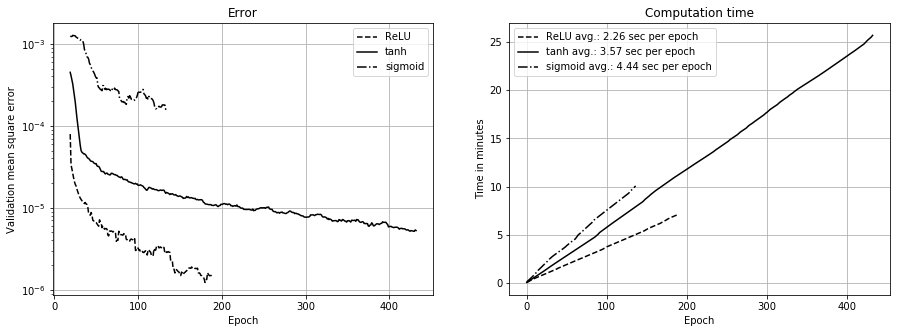

In [19]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title("Error", fontsize=12)
plt.xlabel('Epoch')
plt.ylabel('Validation mean square error')
plt.plot(hist_relu['epoch'], hist_relu['val_mean_squared_error'].rolling(20).mean(),
         "k--", linewidth=1.5, label="ReLU")
plt.plot(hist_tanh['epoch'], hist_tanh['val_mean_squared_error'].rolling(20).mean(),
         "k-", linewidth=1.5, label="tanh")
plt.plot(hist_sigmoid['epoch'], hist_sigmoid['val_mean_squared_error'].rolling(20).mean(),
         "k-.", linewidth=1.5, label="sigmoid")
plt.grid(True)
plt.legend()
plt.yscale('log')

plt.subplot(122)
plt.title("Computation time", fontsize=12)
plt.xlabel('Epoch')
plt.ylabel('Time in minutes')
plt.plot(hist_relu['epoch'], hist_relu['time'] / 60.,
         "k--", linewidth=1.5, label="ReLU avg.: 2.26 sec per epoch")
plt.plot(hist_tanh['epoch'], hist_tanh['time'] / 60.,
         "k-", linewidth=1.5, label="tanh avg.: 3.57 sec per epoch")
plt.plot(hist_sigmoid['epoch'], hist_sigmoid['time'] / 60.,
         "k-.", linewidth=1.5, label="sigmoid avg.: 4.44 sec per epoch")
plt.grid(True)
plt.legend()


plt.savefig('/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Other/AF_comparison.png',
            bbox_inches='tight');

plt.show()

In [17]:
print(604.378863 / 136)
print(1541.016070 / 432)
print(426.888828 / 189)

4.443962227941177
3.5671668287037033
2.2586710476190475
